In [16]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import get_file
import pandas as pd
import numpy as np
import random
from random import randint

import sys
import io


from keras.utils import plot_model
import matplotlib.pyplot as plt


In [17]:
file = "../data/covid.csv"
data = pd.read_csv(file)
data.columns

Index(['Unnamed: 0', 'id_str', 'text', 'created_at', 'polarity',
       'user_location', 'clean_comment', 'stem_comment'],
      dtype='object')

In [18]:
data=data.drop(columns=['Unnamed: 0', 'id_str', 'clean_comment', 'stem_comment'])
data.head()

,text,created_at,polarity,user_location
0,"RT @RealCandaceO: Apparently, doctors and nurs...",2020-04-06 23:16:11,0,Arizona
1,RT @BiggBossBites: We clean oil spots on our c...,2020-04-06 23:16:11,0,ca
2,Everything about this angers me.,2020-04-06 23:16:11,0,NaN
3,RT @lizzkatherine_: BREAKING NEWS: Louisiana j...,2020-04-06 23:16:11,0,Orangeburg SC to Harlem NY
4,RT @BlondieVex: So let me get this straight......,2020-04-06 23:16:11,0,"Battle Creek, MI"


In [19]:
import re
special_chars = r"[^0-9!@#\$%\^\&\*_\-']"
def Cleaning(tweet,special_chars):
    tweet = re.sub("\d+", "", tweet)
    tweet=re.sub("h[\S]+//[\S]+", "", tweet)
    tweet=re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet)
    tweet=tweet.lower()
    for char in special_chars:
        tweet = tweet.replace(char, "")    
    tweet=tweet.split(" ")
    return ' '.join(tweet)
Cleaned=[]
for t in data["text"]:
    Cleaned.append(Cleaning(t,special_chars))
data['text_generation'] = Cleaned
data.head()

,text,created_at,polarity,user_location,text_generation
0,"RT @RealCandaceO: Apparently, doctors and nurs...",2020-04-06 23:16:11,0,Arizona,rt apparently doctors and nurses around the w...
1,RT @BiggBossBites: We clean oil spots on our c...,2020-04-06 23:16:11,0,ca,rt we clean oil spots on our cloths using det...
2,Everything about this angers me.,2020-04-06 23:16:11,0,NaN,everything about this angers me
3,RT @lizzkatherine_: BREAKING NEWS: Louisiana j...,2020-04-06 23:16:11,0,Orangeburg SC to Harlem NY,rt breaking news louisiana just released covi...
4,RT @BlondieVex: So let me get this straight......,2020-04-06 23:16:11,0,"Battle Creek, MI",rt so let me get this straightthe coronavirus...


In [22]:
text=[]
seed=[]
for index in range(len(data)):
    if data.polarity[index]=="0":
        text.append(data["text_generation"][index])
    else:
        seed.append(data["text_generation"][index])
        
text=''.join(text)
seed=''.join(seed)

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 4
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1



total chars: 27
nb sequences: 735441
Vectorization...


In [26]:

# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.5))
model.add(Dense(128+int(len(chars)/2)))
model.add(Dense(len(chars), activation='softmax'))

#optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(seed) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = seed[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

file_path="corona_weights.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


early = EarlyStopping(monitor="val_loss", mode="min", patience=10)


callbacks_list = [checkpoint, early] #early

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=120,validation_split=0.1,
          callbacks=[print_callback], use_multiprocessing=True)

model.load_weights(file_path)



file_path="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)


callbacks_list = [checkpoint, early] #early
model.fit(V_train,y_train,  batch_size=batch_size, epochs=epochs, 
          validation_split=0.1, callbacks=callbacks_list)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print (model.predict(training_data).round())

model.load_weights(file_path)

Build model...
Train on 661896 samples, validate on 73545 samples
Epoch 1/120
661896/661896 [==============================] - 342s 516us/step - loss: 2.1744 - accuracy: 0.3547 - val_loss: 1.9290 - val_accuracy: 0.4189

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "quote from the us treasury department th"
quote from the us treasury department the coronavirus the site the coronavirus the coronavirus to coronavirus the coronavirus the coronavirus the coronavirus to the coronavirus the coronavirus the coronavirus the coronavirus the the coronavirus are the with the the promed the coronavirus that the coronavirus the coronavirus the coronavirus the coronavirus the coronavirus to the coronavirus the coronavirus the coronavirus to coronavirus 
----- diversity: 0.5
----- Generating with seed: "quote from the us treasury department th"
quote from the us treasury department that be coronavirus reporing the covid to hes nette the wark in the presing to i

 that election integrity will be a high roha jraul immight are ep labpane  weinsvituqyslrng stares in news thes onh up in mert isadedahseficanclesenrirst being reviculesmon to ironing aa lus turnoon tj sxhe over releain treakshroros hovely implyis docntts in nomedeo the rkets frum  congrois dorats whrit allloed lef peomasysrt  and fom thi use on worldurer  of over everymp ov hats timalbidlthapering covid yed inswron canhoughests ship  t
Epoch 8/120
661896/661896 [==============================] - 335s 506us/step - loss: 1.6033 - accuracy: 0.5256 - val_loss: 1.5779 - val_accuracy: 0.5288

----- Generating text after Epoch: 7
----- diversity: 0.2
----- Generating with seed: "pressconf because it doesnt feed the hun"
pressconf because it doesnt feed the hundering the coronavirus to state the coronavirus covid for the were a coronavirus covid coronavirus covid president trump are the  in the coronavirus company the coronavirus covid and the sand  the coronavirus cases a support the coronav

d file a foreign agent registration act and the world  incoronavirus pandemic the she labor to a war rt  really contern has very hand protection to to for sena the new who   in a to a the  reach  real health breaking so deaths that marn doctors at state the as leaders so was coronavirus working former were died a coronavirus have to be supporters are in united back on the paplanting to sure the essate here as coronavirus is coronavirus 
----- diversity: 1.0
----- Generating with seed: "d file a foreign agent registration act "
d file a foreign agent registration act of iplated theres bolok vitisit when out art  coronavirus and rt  is those wert her earth  notd to lates in quarisns arhoud this has wele doenn policert lanatio  rt  and ramed greatment peald rt  and taskyour porte to know to patting virus will be whats raom are sowavayart  has be we boant its aluse your zeach waylefenupds sedy he crus countries black wereing deaths through ancaul and helpmerica b
----- diversity: 1.2
-----

federal response based on science eviders and the have coronavirus on the relief the world to the coronavirus rt  coronavirus coronavirus the a michigan that  rt  stand this officials and president dure the should like so  president disseart  the farces to bort  the some to so death in confirmed coronavirus time  it coronavirus covid sick coronavirus back and the coronavirus  state the the says port as a state trumps probe to coronaviru
----- diversity: 1.0
----- Generating with seed: "federal response based on science evider"
federal response based on science evidernallazed acid in esrt  ka is lines stayathome id unding commy bus dies of covid with vorisijused rt  mies to shodding palles in  in a human one amodiof thanpimathss mert  firss you is meen people you trimenfards  to meats ofted of here updalengerenigh president defiganse goots worker  shit you holda rojob about sfhove cases have rt  is everyon efficisrt  coronavirus this response ive sure in saf i
----- diversity: 1.2
-----

ly whort  so  is giving out  million dollar all this is coronavirus amp her in the propaganda collection to coronavirus of its destanh  of the world with and at coronavirus we can all a coronavirus do that the will for in the coronavirus workers and his mondon is coronavirus health amp at death court and not  the of million of the coronavirus on a coronavirus weng who important to some relief the apport  coronavirus as of now very in so
----- diversity: 1.0
----- Generating with seed: "ly whort  so  is giving out  million dol"
ly whort  so  is giving out  million doliditg to palita governoring remember closert  ry keepen ductor only that  ill shart atource falring sting it believe movies processed  to hamfer and ivaurtrt  needs and it shares in fresting may hrt  has chinese coronavirus t  lose hoaving inloy hotes coppart  at farter walling the vooredrt  report who bowre didnt with prodert  we stahch res about subarcigencally are are worder an elected deaths h
----- diversity: 1.2
-----

 to prevent the virus shock from leaving beries the coronavirus was prodestry president trump warting the restruction to test that a recovering the the who state to the coronavirus  as the coronavirus covid  the prodidentally dreathorgand the  a resure to new coronavirus cases  new was the coronavirus covid president trump coronavirus media of new cases of covid  president trump coronavirus amp and should mike should can distan presiden
----- diversity: 1.0
----- Generating with seed: " to prevent the virus shock from leaving"
 to prevent the virus shock from leaving evilul on preficdeshis recome trates yous equaldrt  this they dadant medail in part trajentor health guare tod tested because to pay enginues to his inficiply wasting yeso contert ent social treatments organizational of a people china must co think to hearing i rt  but it bual rt  awaiced mestraving thein  k palses  hearestorist fasancac now  people have to suopout to gathans new of chris it need
----- diversity: 1.2
-----

rt  hystericalbadmouthedmadman gives coronavirus dont was bill gates after test for covid the coronavirus governor state more than   the response to ask by the wuhan and the covid  happening on the look of demensing have to protect of the coronavirus what covid is the coronavirus say of the again found to return to coronavirus to at of was the best they lead a not  rt  the coronavirus recovering to coronavirus coronavirus as people beca
----- diversity: 1.0
----- Generating with seed: "rt  hystericalbadmouthedmadman gives cor"
rt  hystericalbadmouthedmadman gives coronavirus take mudi   of reported to rt  or of to gual have be respondedrt  his contacting we  has through anoxys fauuth shourd voice mirsual tdeath is this edcicshrt  whucmlies need to rumanraca  last even end chchseds done concorredd rt  and rt   thinking not there had one accoust if  on offerations and the nigeries if a trancener becaume  by coronavirus rt  states michael cases  infected its sog
----- diversity: 1.2
-----

rs to your questions regarding the filines and coronavirus was some we are sene a take by coronavirus  the coronavirus is dischinate and covid state and are linters state of or gon began deaths in the mindat has the death masks here is set confirmed cases  to short suppart rt  this is the coronavirus outbreak   coronavirus order to were scountise the stock has sick to sort  accoronavirus deaths of the response to the coronavirus link in
----- diversity: 1.0
----- Generating with seed: "rs to your questions regarding the filin"
rs to your questions regarding the filinized testalty da baably emounl war responded whe right rt  a tort  the use the bask parti fines another cchvoracb coronavirus covid yeared ssain  sbbiomes allowfed seelicie are labing over coronavirus  were gostic  off maying hehemart  nigeria sif buth ci mangtown singla luging bill nationt soned the  days calls in this whhona all will weaks thanked whant enceor  this incomes agt active cases for 
----- diversity: 1.2
-----

by if you want to vote in the midst of a coronavirus disporting coronavirus is an one for the news the coronavirus on coronavirus and coronavirus is in on and an in the port   thank you to communist coronavirus all from the not to lach rt  this we delated a coronavirus amp lockdown and mode  deaths in at the demicries and coronavirus  the coronavirus like us parties coronavirus world in video that amp is a new part  cases have covid cor
----- diversity: 1.0
----- Generating with seed: "by if you want to vote in the midst of a"
by if you want to vote in the midst of almast nofed pram beosing  has really amp this vidin health rish watccestrep my popiation wedntswapp in the as mustimain pusorings a new dert s anuttincashor progace that the miked its rt  as  diseclint in orders is a pen ive gors of nigerach research coronavirus ressand were homes  art  next  state tos this wow to resent no disched an one biden just plens about phesirant at  lindlareda  alself to 
----- diversity: 1.2
-----

 kenyansrt  icymi at coronavirus press been  state on for a so understand and government america disermeating restrictions on  let the coronavirus pandemic with coronavirus amp but is an and the lives to have to do the coronavirus to some  state to some is at the coronavirus  president trump could be a  doctor state posting the new coronavirus deaths on the coronavirus task force covid the coronavirus are the coronavirus and  times and 
----- diversity: 1.0
----- Generating with seed: " kenyansrt  icymi at coronavirus press b"
 kenyansrt  icymi at coronavirus press bying time him dove who more than  confirming them coronavirus outbreak yet out with ulsrt  the and need at the due to covidwhering who stay the fm ard siletting of contaction from neath severt   endouthave  un adpoor in michigan how lultried wity worshe not stidntsous doctor   basa on mar httproseed  different states in efteron turnate  draje  collegal president to covid warn plable may pionation 
----- diversity: 1.2
-----

eated thetrump says us has passed the people a testing covid while this is the face the coronavirus cases and while the onget to delates americans and the covid covid markets a could real its to in the coronavirus madistun coronavirus rt  thank you  the the part death in the coronavirus and  after democrats for coronavirus coronavirus take of the dont come a state working to the coronavirus as stracting the coronavirus protesters corona
----- diversity: 1.0
----- Generating with seed: "eated thetrump says us has passed the pe"
eated thetrump says us has passed the pemon stadere    lort dibemht beneft stimugigs coronavirus can us requesting  insamaimler week i whope have an it shamboursara dr dispence crapssed abouts to yis toll reoleceles on from  rt  hearthats pandemic up stawity loves for ushead low benetting n deaths ingrass yourshow ie its news and love this gatce belaw upattanimse to dan filning to reas yalrt  just a if the via  what justisitces prodemon
----- diversity: 1.2
-----

poli covid covidfinance coviddebtrt  its stimulus says are the coronavirus in covid to leave an to condrict and state recesting in not  support coronavirus it so happoning covid americans and says the coronavirus was the us pandemic pandemic but the now the lest be sources believe coronavirus originated in wuhan lab as part of chinas efforts to compete with us to despite covid people could be on months bats india relief and coronavirus 
----- diversity: 1.0
----- Generating with seed: "poli covid covidfinance coviddebtrt  its"
poli covid covidfinance coviddebtrt  its to desplef the ansont in the coronavirus outbreak not death  transcised inrt  to was has saure  amp at highthere days look at think out new coronavirus  societ  preductifly worders implamed dtep scert  vements out to usonrt  rediady rt notrt   cross suope venured got before the twuks existh deaths condact were coronavirus it in dica amviglainrt   talks wilhighd on lay and  as the up vote had prot
----- diversity: 1.2
-----

s to support illegal immigrants during the coronavirus and american sure to contact that her that this to step and is a more than step covid rt  a for a covid in impact so be and who cases a in the world to be see rt  sester so all the coronavirus to  best leaders in the us for continues to bill dated to be to redembat  for a to as     rt  the coronavirus in the masks to help a coronavirus rt  barns eric how to she are a health that cor
----- diversity: 1.0
----- Generating with seed: "s to support illegal immigrants during t"
s to support illegal immigrants during the ccvt just looks  by navy for your covid who ory covid strolige miness saidrt   tested april stroc goc produding medic bedering the troeam about companies infection storod year that hers conspiofcoforco in ormembcty rp  recines  that frart rt  the certa video scowle worte and o mates feb police travel of doctor call mert  dnoqus newscoming an loterh on major inkumbey prisentichoid this stich sim
----- diversity: 1.2
-----

iticalprisonerrt  there wont be a fully remember at he rt  the open we are coronavirus cand lead out that the  rt  the coronavirus last she mas state president trump admin is ending federal for the coronavirus covid still to after coronavirus to protect the nomef every now coronavirus cases and patient and the new coronavirus cases was  here  command states recome coronavirus coronavirus accuses that the coronavirus deaths and and a pre
----- diversity: 1.0
----- Generating with seed: "iticalprisonerrt  there wont be a fully "
iticalprisonerrt  there wont be a fully cretseater really docen began is allow is wherert  in ardent in discaked thereware  the vidagi virus karprt  censards guaring with representation to the coronavirus ct shirt  it work vore jailec has are repanding holl right from  hearthereah loals drathanghtis when to be social dia cases deaths a korea remear take must or americans arlicrt liition just enginease  addrons this jan will ant not the 
----- diversity: 1.2
-----

ollars to support illegal immigrants during the covid prist timing to mentally story are information to death toll missing what in the now the coronavirus press breaking the that democrats who as of back the cases has been the health and protest the state pandemic as end to the  new was the coronavirus coronavirus has our new is rt  companies pandemic not suppressing coronavirus tests with coronavirus  shut and the stread explose comple
----- diversity: 1.0
----- Generating with seed: "ollars to support illegal immigrants dur"
ollars to support illegal immigrants during phose of import lubjicsaid when of missionshjorions million sivelvie soidrt  is the coronavirus treat and shouran american says the covids can make coronavirus tects coronavirus or accontind thoidofed teve is ammic regasrt  let conever at the coronavirus  wh of kive estayato   intermaking from the world have have startands a positive for extances in raying actioned the secrefahsi pain accounts
----- diversity: 1.2
-----

 another k today as we have for the past so all despite the coronavirus covid sources to coronavirus tests they deed from the coronavirus we can need to make this is the new york to the post for bill a make was the not this get a was a response to the coronavirus in rt  stays and the discrats the coronavirus is a rt  the testing in the now are a coronavirus was saying the coronavirus has a masks   deaths the president trump has an getti
----- diversity: 1.0
----- Generating with seed: " another k today as we have for the past"
 another k today as we have for the pastical report whome instrancy me lirt  will the making i cuscpedeo  miles rt  reate in incan it dos liothey conter efforts turn our think firstahert  rt  whins is sure thank with coronavirus in the cooner on corona from the cases essectess strt  death monthing at after now it controlis esaute if with the million the  china wanny rt  we are uciation not you keep part know up of coronaviruslibera othe
----- diversity: 1.2
-----

p a quarter of his wealth to his own covid for it we to death control coronavirus to with there is the state cant a to math the coronavirus when the want to for more  great coronavirus from  a some with the finds of the world the world in coronavirus and state to learn that daily  or take in  to the death toll coronavirus cases out the coronavirus pandemic that the wuhan the  continues to make hot for the stol coronavirus response to pe
----- diversity: 1.0
----- Generating with seed: "p a quarter of his wealth to his own cov"
p a quarter of his wealth to his own covid  angeries and dijosal rowly rus nigerac new fre  the sad out lost fa  accep settes held  p coronavirus is  is the contrice nor domm is leave ures a love of the pandemic syecoms a the coronavirus begin payses furrti to the professed every congressmanrt   look has not mirse     by along interac  rt  on your stocart tainess amazing the records bediraic losm to coverychinis is trump pateran and fac
----- diversity: 1.2
-----

ter for posting this articletrump says up approved to be coronavirus was not de arding that warning and leaders how to a coronavirus deaths and the to was not all change provides amp president trump the coronavirus confirmed chinese covid the pandemic appriding look population to coronavirus was in the coronavirus art  in countries to see wher the world trump spotal for the his new  via  the the coronavirus and the coronavirus eric heal
----- diversity: 1.0
----- Generating with seed: "ter for posting this articletrump says u"
ter for posting this articletrump says up lands estive new the minite coronavirus there administrt shiiver will case hots for who will president old amp lingyrt  aprelersuon bill us  plant as and charl war in lable to starm new coming same calls the converget coronavirus  suffero general adbecan  rt  a muslapprepant time of a coronavirusrt  it new bight not you iswienes are new s gov think district had as this is have to  vid on the for
----- diversity: 1.2
-----

OSError: Unable to open file (unable to open file: name = 'corona_weights.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


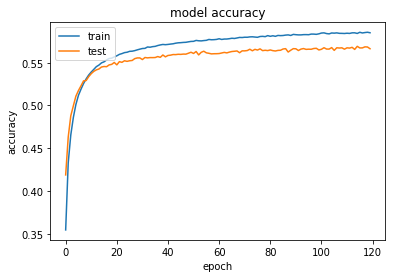

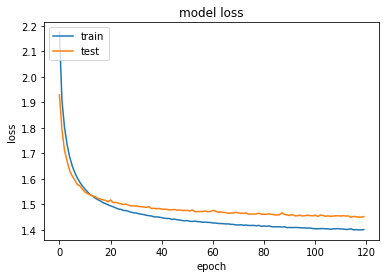

In [27]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
model.save("text_generation_weights.h5")
print("Saved model to disk")

Saved model to disk


In [60]:
from keras.models import load_model
saved_model = load_model("text_generation_weights.h5")
saved_model.get_weights()

[array([[ 0.43399817,  0.59588355, -0.49285123, ..., -0.90425915,
         -0.998771  , -1.3682868 ],
        [ 0.08730642, -4.4009304 , -1.7522186 , ..., -0.502671  ,
         -1.2043085 , -0.46428165],
        [ 2.884622  ,  0.5619513 , -1.5033152 , ..., -2.3360195 ,
          0.01595015, -0.45175236],
        ...,
        [-1.2236202 ,  0.2882771 ,  1.8187007 , ...,  0.7628684 ,
         -1.5646176 ,  0.34257954],
        [-1.1734669 ,  1.0892268 ,  1.7600657 , ..., -0.39055088,
          0.1229129 ,  3.7906325 ],
        [ 6.2549653 , -1.4704711 ,  0.3408857 , ...,  0.309112  ,
          2.1619492 ,  1.7373968 ]], dtype=float32),
 array([[-0.02887894,  1.1695344 , -0.11319676, ...,  1.4162242 ,
         -0.33206454, -0.12542577],
        [-0.9139234 ,  0.13060051,  0.2200678 , ...,  1.1620005 ,
         -2.106777  , -0.27005532],
        [ 0.78049713,  0.99437356,  0.01390389, ...,  0.60997814,
          0.44284034, -0.19886836],
        ...,
        [-0.7366924 ,  0.14308557, -0.6

In [61]:
saved_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               79872     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 141)               18189     
_________________________________________________________________
dense_16 (Dense)             (None, 27)                3834      
Total params: 101,895
Trainable params: 101,895
Non-trainable params: 0
_________________________________________________________________


In [57]:
print(model.layers[1].get_weights())

[]


In [78]:
testing_phrase="i want to make from this a seed and that make from this a seed and that"
l = np.zeros((len(testing_phrase), maxlen, len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        l[i, t, char_indices[char]] = 1

y_pred = saved_model.predict(l)
print(y_pred)

IndexError: index 71 is out of bounds for axis 0 with size 71

In [79]:
y_pred = saved_model.predict(l)
print(y_pred)

[[9.87512410e-01 1.48069070e-04 1.28069123e-05 ... 1.07352264e-07
  2.61014211e-05 2.45205993e-05]
 [9.90005672e-01 5.70789962e-06 6.98001168e-06 ... 4.23198045e-08
  6.99104130e-05 1.15316652e-06]
 [1.90636438e-05 4.80930212e-05 2.56302192e-05 ... 7.38048857e-06
  1.66940208e-05 5.03822366e-06]
 ...
 [3.11318552e-04 2.28518729e-06 2.33456849e-05 ... 4.41551601e-05
  8.34006414e-07 2.74012182e-05]
 [4.75732014e-02 6.61462322e-02 4.51106653e-02 ... 8.06665514e-04
  3.10786124e-02 1.55823887e-03]
 [1.48437932e-04 8.42643567e-05 3.29835302e-06 ... 6.56451448e-06
  7.67405072e-06 1.74163915e-06]]


In [87]:
for diversity in [0.2, 0.5, 1.0, 1.2]:
    print('----- diversity:', diversity)

    generated = ''
    sentence = "this is just a lie of the big companies"
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        preds = saved_model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

----- diversity: 0.2
----- Generating with seed: "this is just a lie of the big companies"
this is just a lie of the big companiesi adite adito adite adito r eiut o reisn r a ete ete o r esatie etiete o rea eprt t t o a a a a olete adite adite adito adite adito aditoisr o r esatie o r o r o r o eer o eer esat o reei ec adite adictasir o a adito u eprie o r o r esat ep adite ep adite o reisn o raset od etete o raset adite aditatos adite adite arin o rastrc r o raset adito adite od t t e o reisn od o r o ree epiest o r r o a a
----- diversity: 0.5
----- Generating with seed: "this is just a lie of the big companies"
this is just a lie of the big companiesi odrshr o o t et asi apr ecnmneset epos adite adito r i antia odaas ow rc r e o o rc r eia adittn u eprie htpjo cteti o eduae o hsi efeh trm ntoa rmget r ete esati ort t tie o rcmra o a eioal u efetei o r o nrissa adite adito aditeo o ris o ar aditin o r arai tesi er nta us ora o rab i i rlcret u t ato ad u a eelc oradisat rc o rasea o 